# 61 Partial PTRS by module

**Origin:** `6_1_partial_PTRS_module.ipynb`  
**Annotated on:** 2025-10-13 06:45

**High-level objective:**  
- Compute module-limited (partial) ci-PTRS and compare case vs control; add significance markers and deltas.

**Notes:**  
- These comments are language-agnostic and focus on intent, inputs, and outputs.  
- Adjust hard-coded paths if needed; prefer `/results_*` for derived artifacts.

---


**Step 1:** Load network or tabular inputs (PPI/GraphML/TSV).

In [18]:
import os
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# load expression profile

def load_probe2gene(probe2gene_path):
    probe2gene = {}
    with gzip.open(probe2gene_path, 'rt') as f:
        inside_table = False
        for line in f:
            if line.startswith('!platform_table_begin'):
                inside_table = True
                header = next(f).strip().split('\t')
                idx_probe = header.index('ID')
                idx_symbol = header.index('Gene Symbol')
                continue
            if inside_table:
                if line.startswith('!platform_table_end'):
                    break
                cols = line.strip().split('\t')
                probe = cols[idx_probe]
                symbol = cols[idx_symbol]
                if symbol and symbol != '---':
                    probe2gene[probe] = symbol.split(' /// ')[0]
    return probe2gene

def load_and_process_expression(expr_path, probe2gene_path):
    probe2gene = load_probe2gene(probe2gene_path)
    expr = pd.read_csv(expr_path, sep='\t', comment='!', index_col=0)
    expr.index = expr.index.astype(str)
    expr = expr[expr.index.isin(probe2gene)]
    expr['gene'] = expr.index.map(probe2gene)
    gene_expr = expr.groupby('gene').mean()
    gene_expr_norm = gene_expr.subtract(gene_expr.mean(axis=1), axis=0)
    return gene_expr_norm

def extract_group_labels(matrix_file):
    with gzip.open(matrix_file, 'rt') as f:
        for line in f:
            if line.startswith('!Sample_title'):
                sample_titles = line.strip().split('\t')[1:]
                break
    group_labels = []
    for title in sample_titles:
        if re.search(r'control group', title, re.IGNORECASE):
            group_labels.append('Control')
        elif re.search(r'disease group', title, re.IGNORECASE):
            group_labels.append('Disease')
        else:
            group_labels.append('Unknown')
    return group_labels

# 1. Load expression

gene_expr_norm = load_and_process_expression(
    '/mnt/f/10_osteo_MR/datasets/gse123568/GSE123568_series_matrix.txt.gz',
    '/mnt/f/10_osteo_MR/datasets/gse123568/GSE123568_family.soft.gz'
)

# 2. Get group labels
group_labels = extract_group_labels('/mnt/f/10_osteo_MR/datasets/gse123568/GSE123568_series_matrix.txt.gz')





**Step 2:** Load network or tabular inputs (PPI/GraphML/TSV).

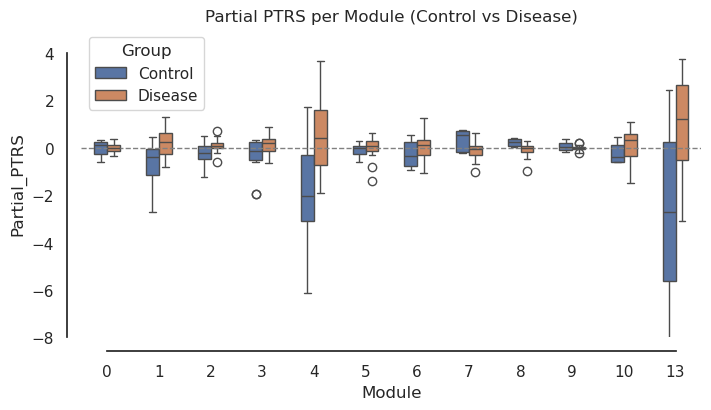

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==== Input paths ====
membership_file = "/mnt/f/10_osteo_MR/results_network/largest_causal_subnet_A2_a6_g0.001832981/all_membership.tsv"
PATH_MR = "/mnt/f/10_osteo_MR/results_mr_ptrs/PTRS/bulk_crossmodal_meta_beta.tsv"

# ==== Load module membership ====
# expected columns: gene, module
membership = pd.read_csv(membership_file, sep="\t")
membership.columns = ["gene", "module"]

# Add pseudo-module 13 for all nodes
membership_all = membership.copy()
membership_all["module"] = 13
membership = pd.concat([membership, membership_all], ignore_index=True)

# ==== Load MR betas ====
mr_df = pd.read_csv(PATH_MR, sep="\t")
mr_df = mr_df[["gene", "meta_beta_common"]].dropna()

# ==== Prepare gene → beta mapping ====
beta_map = dict(zip(mr_df["gene"], mr_df["meta_beta_common"]))

# ==== Filter expression to genes with betas ====
common_genes = set(gene_expr_norm.index).intersection(beta_map.keys())
expr = gene_expr_norm.loc[list( common_genes)]

# Align betas
betas = pd.Series({g: beta_map[g] for g in common_genes})

# ==== Compute partial PTRS per module ====
# PTRS_i = sum(beta_g * expr_gi) over genes in module
results = []
for module in sorted(membership["module"].unique()):
    module_genes = membership.loc[membership["module"] == module, "gene"]
    module_genes = [g for g in module_genes if g in common_genes]
    if len(module_genes) == 0:
        continue
    sub_expr = expr.loc[module_genes]
    sub_betas = betas[module_genes]
    # Matrix multiplication: (genes × samples) → (samples)
    ptrs_values = np.dot(sub_betas.values, sub_expr.values)
    
    for i, val in enumerate(ptrs_values):
        results.append({
            "Sample": expr.columns[i],
            "Group": group_labels[i],
            "Module": module,
            "Partial_PTRS": val
        })

ptrs_df = pd.DataFrame(results)

# ==== Plot ====
sns.set(style="white")

fig, ax = plt.subplots(figsize=(8, 4))
g = sns.boxplot(
    data=ptrs_df,
    x="Module", y="Partial_PTRS", hue="Group" ,
    width=0.5 
    # kind="violin",   height=8, aspect=3  , split=True  # , 
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# g.set_axis_labels("Module", "Partial PTRS")
plt.ylim( -8, 5 ) 
plt.title("Partial PTRS per Module (Control vs Disease)")
sns.despine(offset=10, trim=True);

plt.show()




**Step 3:** Visualization: figures/heatmaps/summary plots.

/tmp/ipykernel_10383/949388223.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[m] for m in order])


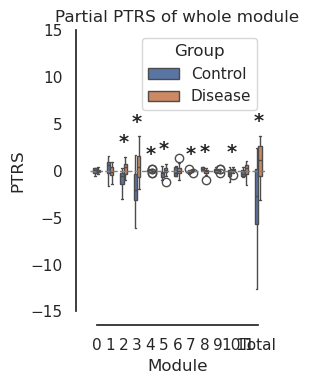

    Module      pval  label
0        0  0.790628      0
1        1  0.146386      1
2        2  0.000983      2
3        3  0.006896      3
4        4  0.032389      4
5        5  0.013022      5
6        6  0.462939      6
7        7  0.004263      7
8        8  0.000983      8
9        9  0.356828      9
10      10  0.008307     10
11      11  0.054740     11
12      13  0.010908  Total


In [14]:
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Order and pretty labels ---
order = sorted(ptrs_df["Module"].unique())
label_map = {m: ( "Total" if m == 13 else str(m) ) for m in order}  # 0..12 as numbers, 13 -> 'Total'

#order = [13]
#ptrs_df = ptrs_df[ ptrs_df['Module'] == 13 ] 

# --- Compute p-values per module (Control vs Disease) ---
pvals = {}
for m in order:
    sub = ptrs_df[ptrs_df["Module"] == m]
    a = sub.loc[sub["Group"] == "Control", "Partial_PTRS"].values
    b = sub.loc[sub["Group"] == "Disease", "Partial_PTRS"].values
    if len(a) > 0 and len(b) > 0:
        # Mann–Whitney U (two-sided)
        stat, p = mannwhitneyu(a, b, alternative="two-sided")
    else:
        p = np.nan
    pvals[m] = p


# --- Plot (boxplot) ---
sns.set(style="white")
fig, ax = plt.subplots(figsize=(3, 4))

g = sns.boxplot(
    data=ptrs_df, x="Module", y="Partial_PTRS", hue="Group",  width=0.5 
    # kind="violin", cut=0, inner="box", order=order, height=6, aspect=2
)

#ax = g.axes[0, 0]

# Replace tick labels with pretty ones
ax.set_xticklabels([label_map[m] for m in order])

# --- Add significance stars (* if p<0.05) ---
# y positions: slightly above the per-module max
ymax_by_m = ptrs_df.groupby("Module")["Partial_PTRS"].max().to_dict()
yrange = ptrs_df["Partial_PTRS"].max() - ptrs_df["Partial_PTRS"].min()
offset = 0.03 * (yrange if yrange > 0 else 1.0)

for xi, m in enumerate(order):
    p = pvals.get(m, np.nan)
    if (not np.isnan(p)) and (p < 0.05):
        y = ymax_by_m.get(m, 0.0) + offset
        # center between the two hue violins
        ax.text(xi, y, "*", ha="center", va="bottom", fontsize=14, fontweight="bold")

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

ax.set_xlabel("Module")
ax.set_ylabel("PTRS")
ax.set_title("Partial PTRS of whole module")
#g._legend.set_title("Group")
plt.ylim( -15, 15) 
plt.title("Partial PTRS of whole module")
sns.despine(offset=10, trim=True);


plt.tight_layout()
plt.show()

# Optional: print the p-values table
pval_table = (pd.Series(pvals, name="pval")
                .rename_axis("Module")
                .reset_index()
                .assign(label=lambda d: d["Module"].map(label_map)))
print(pval_table)


**Step 4:** Run a processing or analysis step.

In [37]:
expr.head()

,GSM3507251,GSM3507252,GSM3507253,GSM3507254,GSM3507255,GSM3507256,GSM3507257,GSM3507258,GSM3507259,GSM3507260,...,GSM3507281,GSM3507282,GSM3507283,GSM3507284,GSM3507285,GSM3507286,GSM3507287,GSM3507288,GSM3507289,GSM3507290
gene,,,,,,,,,,,,,,,,,,,,,
CCM2,-0.380991,0.015858,-0.019453,-0.046470,-0.020385,-0.273038,0.003208,0.253131,-0.089298,-0.123292,...,0.073598,-0.139107,0.117193,-0.167663,0.209973,0.073174,0.118338,-0.179264,0.145582,0.153809
ATF6,-0.016677,0.055100,-0.089028,-0.481778,-1.088578,-0.618371,-1.078542,0.296226,-0.521034,0.069823,...,0.067906,-0.129538,0.626810,-0.552146,0.997825,-0.006893,0.209623,-0.268397,-0.265866,-0.360389
CFC1,-0.467929,0.423860,0.096174,0.793327,0.627159,-0.050065,0.633342,0.248494,0.416146,-0.333846,...,-0.290306,-0.270653,-0.040528,-0.154008,-0.626446,-0.037005,-0.601121,0.013361,-0.447273,0.226604
CCL24,-0.368295,0.561648,0.258671,0.830345,0.799035,0.254932,1.111113,0.007231,-0.141458,-0.283142,...,-0.044341,-0.164024,0.114927,0.124311,-0.374483,0.182026,-0.712918,-0.236169,-0.562031,0.340274
BATF3,0.226038,0.395300,0.039511,0.032025,0.209786,-0.461273,-0.088863,-0.129713,-0.481265,0.136476,...,0.205549,-0.058145,-0.121551,-0.071730,-0.025448,0.295957,-0.003261,0.101305,-0.081854,-0.068809


**Step 5:** Run a processing or analysis step.

In [24]:
 np.mean( expr.iloc[ expr.index.isin( ['CCM2']) ].T['CCM2' ].to_list() )

-4.4408920985006264e-17

**Step 6:** Run a processing or analysis step.

In [15]:
# group means
ctrl_cols = [s for s, g in zip(expr.columns, group_labels) if g == "Control"]
case_cols = [s for s, g in zip(expr.columns, group_labels) if g == "Disease"]
mean_ctrl = expr[ctrl_cols].mean(axis=1)
mean_case = expr[case_cols].mean(axis=1)
dexpr = (mean_case - mean_ctrl)  # Δexpr = Disease - Control

summary_rows = []
for m in sorted(membership["module"].unique()):
    mg = membership.loc[membership["module"] == m, "gene"]
    mg = [g for g in mg if g in expr.index and g in betas.index]
    if not mg:
        continue
    b = betas.loc[mg]
    dx = dexpr.loc[mg]
    contrib = b * dx

    # stats
    r = np.corrcoef(b.values, dx.values)[0,1] if len(mg) > 2 else np.nan
    pos = b[b>0]; neg = b[b<0]
    row = dict(
        Module=m,
        n_genes=len(mg),
        frac_pos=(pos.size/len(mg)),
        mean_beta_pos=pos.mean() if pos.size else np.nan,
        mean_beta_neg=neg.mean() if neg.size else np.nan,
        corr_beta_dexpr=r,
        delta_PTRS=contrib.sum()  # equals mean PTRS(Disease) - mean PTRS(Control) for module
    )
    # top contributors
    top_pos = contrib.sort_values(ascending=False).head(5).index.tolist()
    top_neg = contrib.sort_values(ascending=True).head(5).index.tolist()
    row["top_pos_contributors"] = ";".join(top_pos)
    row["top_neg_contributors"] = ";".join(top_neg)
    summary_rows.append(row)

module_summary = pd.DataFrame(summary_rows).sort_values("Module")
print(module_summary)


    Module  n_genes  frac_pos  mean_beta_pos  mean_beta_neg  corr_beta_dexpr  \
0        0       34  0.264706       0.173179      -0.128793         0.013400   
1        1       34  0.352941       0.181772      -0.162809        -0.026169   
2        2       56  0.625000       0.145232      -0.126559         0.081416   
3        3       35  0.428571       0.351166      -0.153398         0.317058   
4        4       18  0.444444       0.171251      -0.130054        -0.086451   
5        5       31  0.419355       0.175216      -0.153827         0.141987   
6        6       29  0.448276       0.140453      -0.184860         0.134767   
7        7        9  0.111111       0.041240      -0.127611         0.199772   
8        8       13  0.538462       0.081830      -0.142417        -0.260033   
9        9        9  0.666667       0.113370      -0.131181        -0.362892   
10      10        3  1.000000       0.224781            NaN         0.974110   
11      11        8  0.500000       0.15

**Step 7:** Run a processing or analysis step.

module
13    2470
0      453
1      324
2      323
3      313
4      292
5      250
6      204
7      169
8       79
9       46
10      14
11       3
Name: count, dtype: int64

**Step 8:** Load network or tabular inputs (PPI/GraphML/TSV).

0 96.0 0.09470997485228519
1 52.0 0.0023238003463012438
2 52.0 0.0023238003463012438
3 178.0 0.3903649625488059
4 108.0 0.19489204677234584
5 192.0 0.19489204677234584
6 153.0 0.9377589428180784
7 152.0 0.9626310820312192
8 61.0 0.005704933431119247
9 244.0 0.0034952701128578537
10 130.0 0.5424729569532013
13 31.0 0.00021448233973810725


/tmp/ipykernel_10383/1817526133.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[m] for m in order])


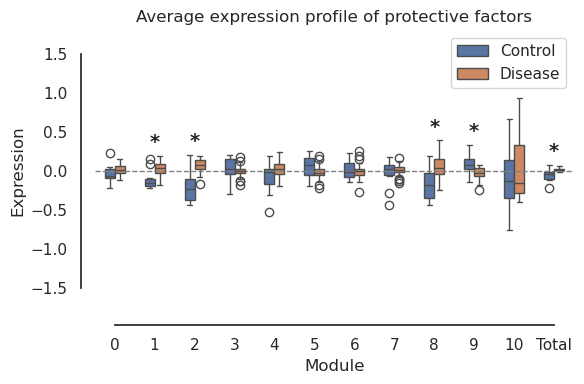

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==== Input paths ====
membership_file = "/mnt/f/10_osteo_MR/results_network/largest_causal_subnet_A2_a6_g0.001832981/all_membership.tsv"
PATH_MR = "/mnt/f/10_osteo_MR/results_mr_ptrs/PTRS/bulk_crossmodal_meta_beta.tsv"

# ==== Load module membership ====
# expected columns: gene, module
membership = pd.read_csv(membership_file, sep="\t")
membership.columns = ["gene", "module"]

# Add pseudo-module 13 for all nodes
membership_all = membership.copy()
membership_all["module"] = 13

membership = pd.concat([membership, membership_all], ignore_index=True)

# ==== Load MR betas ====
mr_df = pd.read_csv(PATH_MR, sep="\t")
mr_df = mr_df[["gene", "meta_beta_common"]].dropna()

# ==== Prepare gene → beta mapping ====
beta_map_ = dict(zip(mr_df["gene"], mr_df["meta_beta_common"]))

# ==== Filter expression to genes with betas ====

# toggle : protective , risk
# 
#toggle = 'risk'
toggle = 'protective'

beta_map = {}
for k in beta_map_:
    if toggle == 'risk':
        if beta_map_[k] > 0:
            beta_map[ k] = beta_map_[k]
    elif toggle =='protective':
        if beta_map_[k] < 0:
            beta_map[ k] = beta_map_[k]        

common_genes = set(gene_expr_norm.index).intersection(beta_map.keys())
expr = gene_expr_norm.loc[list( common_genes)]

# Align betas
betas = pd.Series({g: beta_map[g] for g in common_genes})



# ==== Compute partial PTRS per module ====
# PTRS_i = sum(beta_g * expr_gi) over genes in module

order = sorted(membership["module"].unique())

label_map = {m: ( "Total" if m == 13 else str(m) ) for m in order}  # 0..12 as numbers, 13 -> 'Total'


results = []
for module in order: #  sorted(membership["module"].unique()):
    module_genes = membership.loc[membership["module"] == module, "gene"]
    module_genes = [g for g in module_genes if g in common_genes]
    if len(module_genes) == 0:
        continue
    sub_expr = expr.loc[module_genes]
    sub_betas = betas[module_genes]
    # Matrix multiplication: (genes × samples) → (samples)
    ptrs_values = np.dot(sub_betas.values/sub_betas.values , sub_expr.values)/len( sub_betas.values)
    
    for i, val in enumerate(ptrs_values):
        results.append({
            "Sample": expr.columns[i],
            "Group": group_labels[i],
            "Module": module,
            "Expression": val
        })


ptrs_df = pd.DataFrame(results)


order = sorted(ptrs_df["Module"].unique())



# --- Compute p-values per module (Control vs Disease) ---
pvals = {}
for m in order:
    sub = ptrs_df[ptrs_df["Module"] == m]
    a = sub.loc[sub["Group"] == "Control", "Expression"].values
    b = sub.loc[sub["Group"] == "Disease", "Expression"].values
    if len(a) > 0 and len(b) > 0:
        # Mann–Whitney U (two-sided)
        stat, p = mannwhitneyu(a, b, alternative="two-sided")
        print( m, stat, p )
    else:
        p = np.nan
    pvals[m] = p



# ==== Plot ====
sns.set(style="white")

fig, ax = plt.subplots(figsize=(6, 4))
g = sns.boxplot(
    data=ptrs_df,
    x="Module", y="Expression", hue="Group" ,
    width=0.5 #  , legend=False
    # kind="violin",   height=8, aspect=3  , split=True  # , 
)


# --- Add significance stars (* if p<0.05) ---
# y positions: slightly above the per-module max
ymax_by_m = ptrs_df.groupby("Module")["Expression"].max().to_dict()
yrange = ptrs_df["Expression"].max() - ptrs_df["Expression"].min()
offset = 0.03 * (yrange if yrange > 0 else 1.0)

for xi, m in enumerate(order):
    p = pvals.get(m, np.nan)
    if (not np.isnan(p)) and (p < 0.05):
        y = ymax_by_m.get(m, 0.0) + offset
        # center between the two hue violins
        ax.text(xi, y, "*", ha="center", va="bottom", fontsize=14, fontweight="bold")


# Replace tick labels with pretty ones
ax.set_xticklabels([label_map[m] for m in order])

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# g.set_axis_labels("Module", "Partial PTRS")
plt.ylim( -1.8,  1.8 ) 

if toggle == 'risk':
    plt.title("Average expression profile of risk factors")

if toggle == 'protective':
    plt.title("Average expression profile of protective factors")

ax.get_legend().set_title("")

sns.despine(offset=10, trim=True);
plt.tight_layout()

if toggle == 'protective':
    plt.savefig( '/mnt/f/10_osteo_MR/results_network/largest_causal_subnet_A2_a6_g0.001832981/gene_expr_protecitive.pdf' )

if toggle == 'risk':
    plt.savefig( '/mnt/f/10_osteo_MR/results_network/largest_causal_subnet_A2_a6_g0.001832981/gene_expr_risk.pdf' )

plt.show()


